<a href="https://colab.research.google.com/github/Somertonman/hackathon_2023/blob/main/graph_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [111]:
%%capture
!pip install pymorphy2
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
%%capture
!pip install python-docx docx

In [113]:
!pip install transformers sacremoses
from transformers import pipeline

qa_pipeline = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import pandas as pd
import spacy
from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [115]:
%%capture
!python -m spacy download ru_core_news_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-23 12:15:51.801466: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


# Data source

In [ ]:
!gdown 1SXKfdEY0Z8L-zR3St4d2zB_vVeyUdBps

In [ ]:
df = pd.read_csv('fin_dataset.csv')
df = df.query('name != "себя"').reset_index().drop(columns='index')
#df = df[['id', 'task_num',
#       'task_text', 'dept', 'task_responsibles_people', 'task_deadline',
#       'position', 'name', 'global_deadline', 'Tasks']]
df.head()

,Unnamed: 0,id,task_num,task_text,dept,position,name
0,0,0,Task1,Закупить книги. Срок завершения: 19 апр 15.,Административно-хозяйственный отдел,специалиста первой категории административно-...,Кравцову И.Е.
1,1,1,Task1,Провести анализ поставщиков для замены вышедше...,Служба ИТ,специалиста третьей категории Службы ИТ,Кима Юрия Ивановича
2,2,1,Task2,Выполнить ремонт кабеля сети передачи данных м...,Служба ИТ,системного администратора,Сергеева Андрея
3,3,1,Task3,Создать и настроить виртуальную машину в соотв...,Служба ИТ,специалистом третьей категории,Кимом Юрием Ивановичем
4,4,2,Task1,Провести рефакторинг программного обеспечения ...,Отдел разработки систем,Контроль над исполнением распоряжения,Абаимовым Симоном


In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian") 

def Convert(string): 
    li = list(string.split(" ")) 
    return li 

def stem(text):
  my_words = Convert(text)
  l = []
  for word in my_words:
    if word != "специалист":
        l.append(stemmer.stem(word))
  return " ".join(l)

In [ ]:
df['position'] = df.apply(lambda x: stem(x['position']), axis=1)

In [ ]:
df['position']

0         специалист перв категор административно-хозяй...
1                         специалист трет категор служб ит
2                                    системн администратор
3                                  специалист трет категор
4                          контрол над исполнен распоряжен
                               ...                        
50448                              специалист перв категор
50449                                администратор баз дан
50450                              специалист втор категор
50451                     руководител отдел разработк сист
50452                                тимлид проектн команд
Name: position, Length: 50453, dtype: object

#spaCy (запускать не обязательно)

In [ ]:
# https://drive.google.com/file/d/1GIak7jmxhucwpr4VAJxEniinMwOmObPv/view?usp=sharing
!gdown 1GIak7jmxhucwpr4VAJxEniinMwOmObPv

Downloading...
From: https://drive.google.com/uc?id=1GIak7jmxhucwpr4VAJxEniinMwOmObPv
To: /content/json.tar
100% 56.1M/56.1M [00:00<00:00, 259MB/s]


In [ ]:
!mkdir json_dataset
!tar -xvf  '/content/json.tar' -C '/content/json_dataset'

In [ ]:
def parse_file(file_name, num):
  df = pd.read_json(file_name).reset_index()

  df['id'] = num

  df = df.query('index not in ("Global_deadline", "Global_supervisor")')
  df['task_text'] = df.apply(lambda x: x['Tasks']['task_text'], axis = 1)
  df['task_responsibles_people'] = df.apply(lambda x: x['Tasks']['task_responsibles_people'], axis = 1)
  df['task_responsibles_groups'] = df.apply(lambda x: x['Tasks']['task_responsibles_groups'], axis = 1)

  df = df[['id', 'index', 'task_responsibles_groups', 'task_responsibles_people']]
  return df.rename(columns={'index':'task_num', 'task_responsibles_groups':'dept'})

In [ ]:
df_emp = parse_file('/content/json_dataset/json/0.json', 0)

for i in tqdm(range (1, 10000)):
  file_name = f"/content/json_dataset/json/{i}.json"
  df_one = parse_file(file_name, i)
  df_emp = pd.concat([df_emp, df_one])

df_emp['task_responsibles_people'] = df_emp['task_responsibles_people'].str.lower()
df_emp = df_emp.reset_index().drop(columns=['index'])
df_emp.head()

100%|██████████| 9999/9999 [02:52<00:00, 58.08it/s]


,id,task_num,dept,task_responsibles_people
0,0,Task1,Административно-хозяйственный отдел,ответственность за исполнение распоряжения воз...
1,1,Task1,Служба ИТ,ответственность за исполнение распоряжения воз...
2,1,Task2,Служба ИТ,контроль над выполнением приказа возложить на ...
3,1,Task3,Служба ИТ,контроль над исполнением распоряжения оставить...
4,2,Task1,Отдел разработки систем,контроль над исполнением распоряжения оставить...


In [ ]:
df_emp_n = df_emp.head(100)

In [ ]:
nlp = spacy.load("ru_core_news_lg")

In [ ]:
df_emp_n['name'] =  df_emp_n.apply(lambda x : ' '.join([ent.text for ent in nlp(x.task_responsibles_people).ents]), axis = 1)
df_emp_n.head()

,id,task_num,dept,task_responsibles_people,name
0,0,Task1,Административно-хозяйственный отдел,ответственность за исполнение распоряжения воз...,кравцову и.е.
1,1,Task1,Служба ИТ,ответственность за исполнение распоряжения воз...,ит
2,1,Task2,Служба ИТ,контроль над выполнением приказа возложить на ...,сергеева андрея
3,1,Task3,Служба ИТ,контроль над исполнением распоряжения оставить...,ит
4,2,Task1,Отдел разработки систем,контроль над исполнением распоряжения оставить...,абаимовым симоном


# Data cleaning

In [ ]:
df.fillna(0, inplace = True)
df.replace('None', 0, inplace = True)


# EDA

In [ ]:
# some basic stats

documents = df['id'].unique()
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()


print('Number of docs:', len(documents))
print('Number of depts in the company:', len(departments) )
print('Number of employees in the company:', len(employees))
print('Number of positions in the company total:', len(positions))

Number of docs: 9999
Number of depts in the company: 8
Number of employees in the company: 95
Number of positions in the company total: 62


## Company departments

In [ ]:
print(departments)

['Административно-хозяйственный отдел' 'Служба ИТ'
 'Отдел разработки систем' 'Бухгалтерия' 'Отдел проектирования'
 'Отдел архитектуры' 'Отдел эксплуатации' 'Отдел тестирования']


## Employees

In [ ]:
print(employees)

[' Кравцову И.Е.' ' Кима Юрия Ивановича' ' Сергеева Андрея'
 ' Кимом Юрием Ивановичем' ' Абаимовым Симоном' ' Абаимова Симона'
 ' Абашкина Ореста' ' Абалкина Зураба' ' Андреевым С.Е.' ' Андреева С.Е.'
 ' собой' ' Александрова А.С.' ' Смирнову О.А.' ' Шихова'
 ' Семеновым И.А.' ' Семенова И.А.' ' Шихова Р.П.' ' Семенову М.С.'
 ' Попова А.А.' ' Абакулова Петра' ' Абалакова Севастьяна' ' Попова И.И.'
 ' Шиховым Р.П.' ' Коптелова Е.В' ' С.С.Галкина'
 ' Сергееву Алену Ивановну' ' Слесарева А.В' ' Абатуровым Борисом'
 ' Миронова К.А.' ' Абатурова Бориса' ' Симонова Н.С.'
 ' Абаковым Алексеем' ' Никишина С.Е.' ' Абашичева Алексея'
 ' Поспелову Н.А.' ' Миронову Т.П.' ' Миронову' ' Мироновой' ' Семенову'
 ' Никишиным С.Е.' ' Поповым И.И.' ' Кравцовой' ' Семеновой'
 ' Ведерникова И.С.' ' Жукова А.В' ' Точнова' ' Ивановым А.А.'
 ' Жуковым А.В' ' Иванова А.А.' ' Р.Е.Артюхина'
 ' Александрова Александра Ивановича' ' Абалаковым Севастьяном'
 ' Абалдуева Олега' ' Петрова В.М.' ' Никитину Ирину Петров

In [ ]:
emp_dictionary = { emp : emp for emp in employees }
emp_dictionary['янина и.а.'] = 'янин и.а.'
emp_dictionary['ким юрий иванович'] = 'ким ю.и.'
emp_dictionary['абаимов симона'] = 'абаимов с.'
emp_dictionary['абаимов симон'] = 'абаимов с.'
emp_dictionary['сергеев андрей'] = 'сергеев а.'
emp_dictionary['абашкин орест'] = 'абашкин о.'
emp_dictionary['абалкин зураб'] = 'абалкин з.'
emp_dictionary['абатуров борис'] = 'абатуров б.'
emp_dictionary['симоново н.с.'] = 'симонов н.с.'
emp_dictionary['абаковый алексей'] = 'абаков а.'
emp_dictionary['абашичев алексей'] = 'абашичев а.'
emp_dictionary['с.с.галкин'] = 'галкин c.c.'
emp_dictionary['сергеев ален иванович'] = 'сергеева а.и.'
emp_dictionary['семёнов'] = 'семёнов и.а.'
emp_dictionary['кравцов'] = 'кравцов и.е.'
emp_dictionary['шихов'] = 'шихов р.п.'
emp_dictionary['абакуловый пётр'] = 'абакулов п.'
emp_dictionary['абалаково севастьян'] = 'абалаков с.'
emp_dictionary['артюхин'] = 'артюхин р.е.'
emp_dictionary['александров александр иванович'] = 'александров а.и.'
emp_dictionary['абалаковый севастьян'] = 'абалаков с.'
emp_dictionary['абалдуев олег'] = 'абалдуев о.'
emp_dictionary['никитин ирина петрович'] = 'никитина и.п.'
emp_dictionary['абалакин михаил'] = 'абалакин м.'
emp_dictionary['сергеев алёна иванович'] = 'сергеева а.и.'
emp_dictionary['петров'] = 'петров в.м.'
emp_dictionary['львов'] = 'львов а.м.'
emp_dictionary['абаков алексей'] = 'абаков а.'
emp_dictionary['анненков'] = 'анненков и.с.'
emp_dictionary['точновый'] = 'точнов с.о.'
emp_dictionary['спецова а.в'] = 'спецов а.в'
emp_dictionary['миронов'] = 'миронов т.п'
emp_dictionary['семёнов'] = 'миронов и.а'
emp_dictionary['коптеловый е.в'] = 'коптелов е.в'
emp_dictionary['точновое с.о.'] = 'точнов с.о.'
emp_dictionary['р.е.артюхин'] = 'артюхин р.е.'

In [ ]:
df['name'] = df['name'].map(emp_dictionary)

# Graph

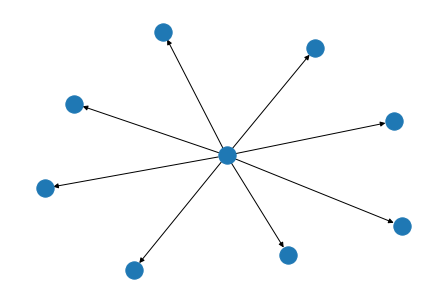

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

DG = nx.DiGraph()

comp_name = 'COMPANY'

for i in list(departments):
    DG.add_edge(comp_name, i)
    

nx.draw(DG)


In [116]:
!gdown 1PvIMSFrs7D7rdmObf-x5J90U4Y-sJeud
# Download manually corrected .csv
df = pd.read_csv('/content/normal_position.csv')
df = df[['normal_name', 'normal_position', 'dept']].rename(columns={'normal_name':'name', 'normal_position':'position'})
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()

Downloading...
From: https://drive.google.com/uc?id=1PvIMSFrs7D7rdmObf-x5J90U4Y-sJeud
To: /content/normal_position.csv
100% 26.5k/26.5k [00:00<00:00, 21.0MB/s]


## Multilevel graph

100%|██████████| 120/120 [00:00<00:00, 741.47it/s]


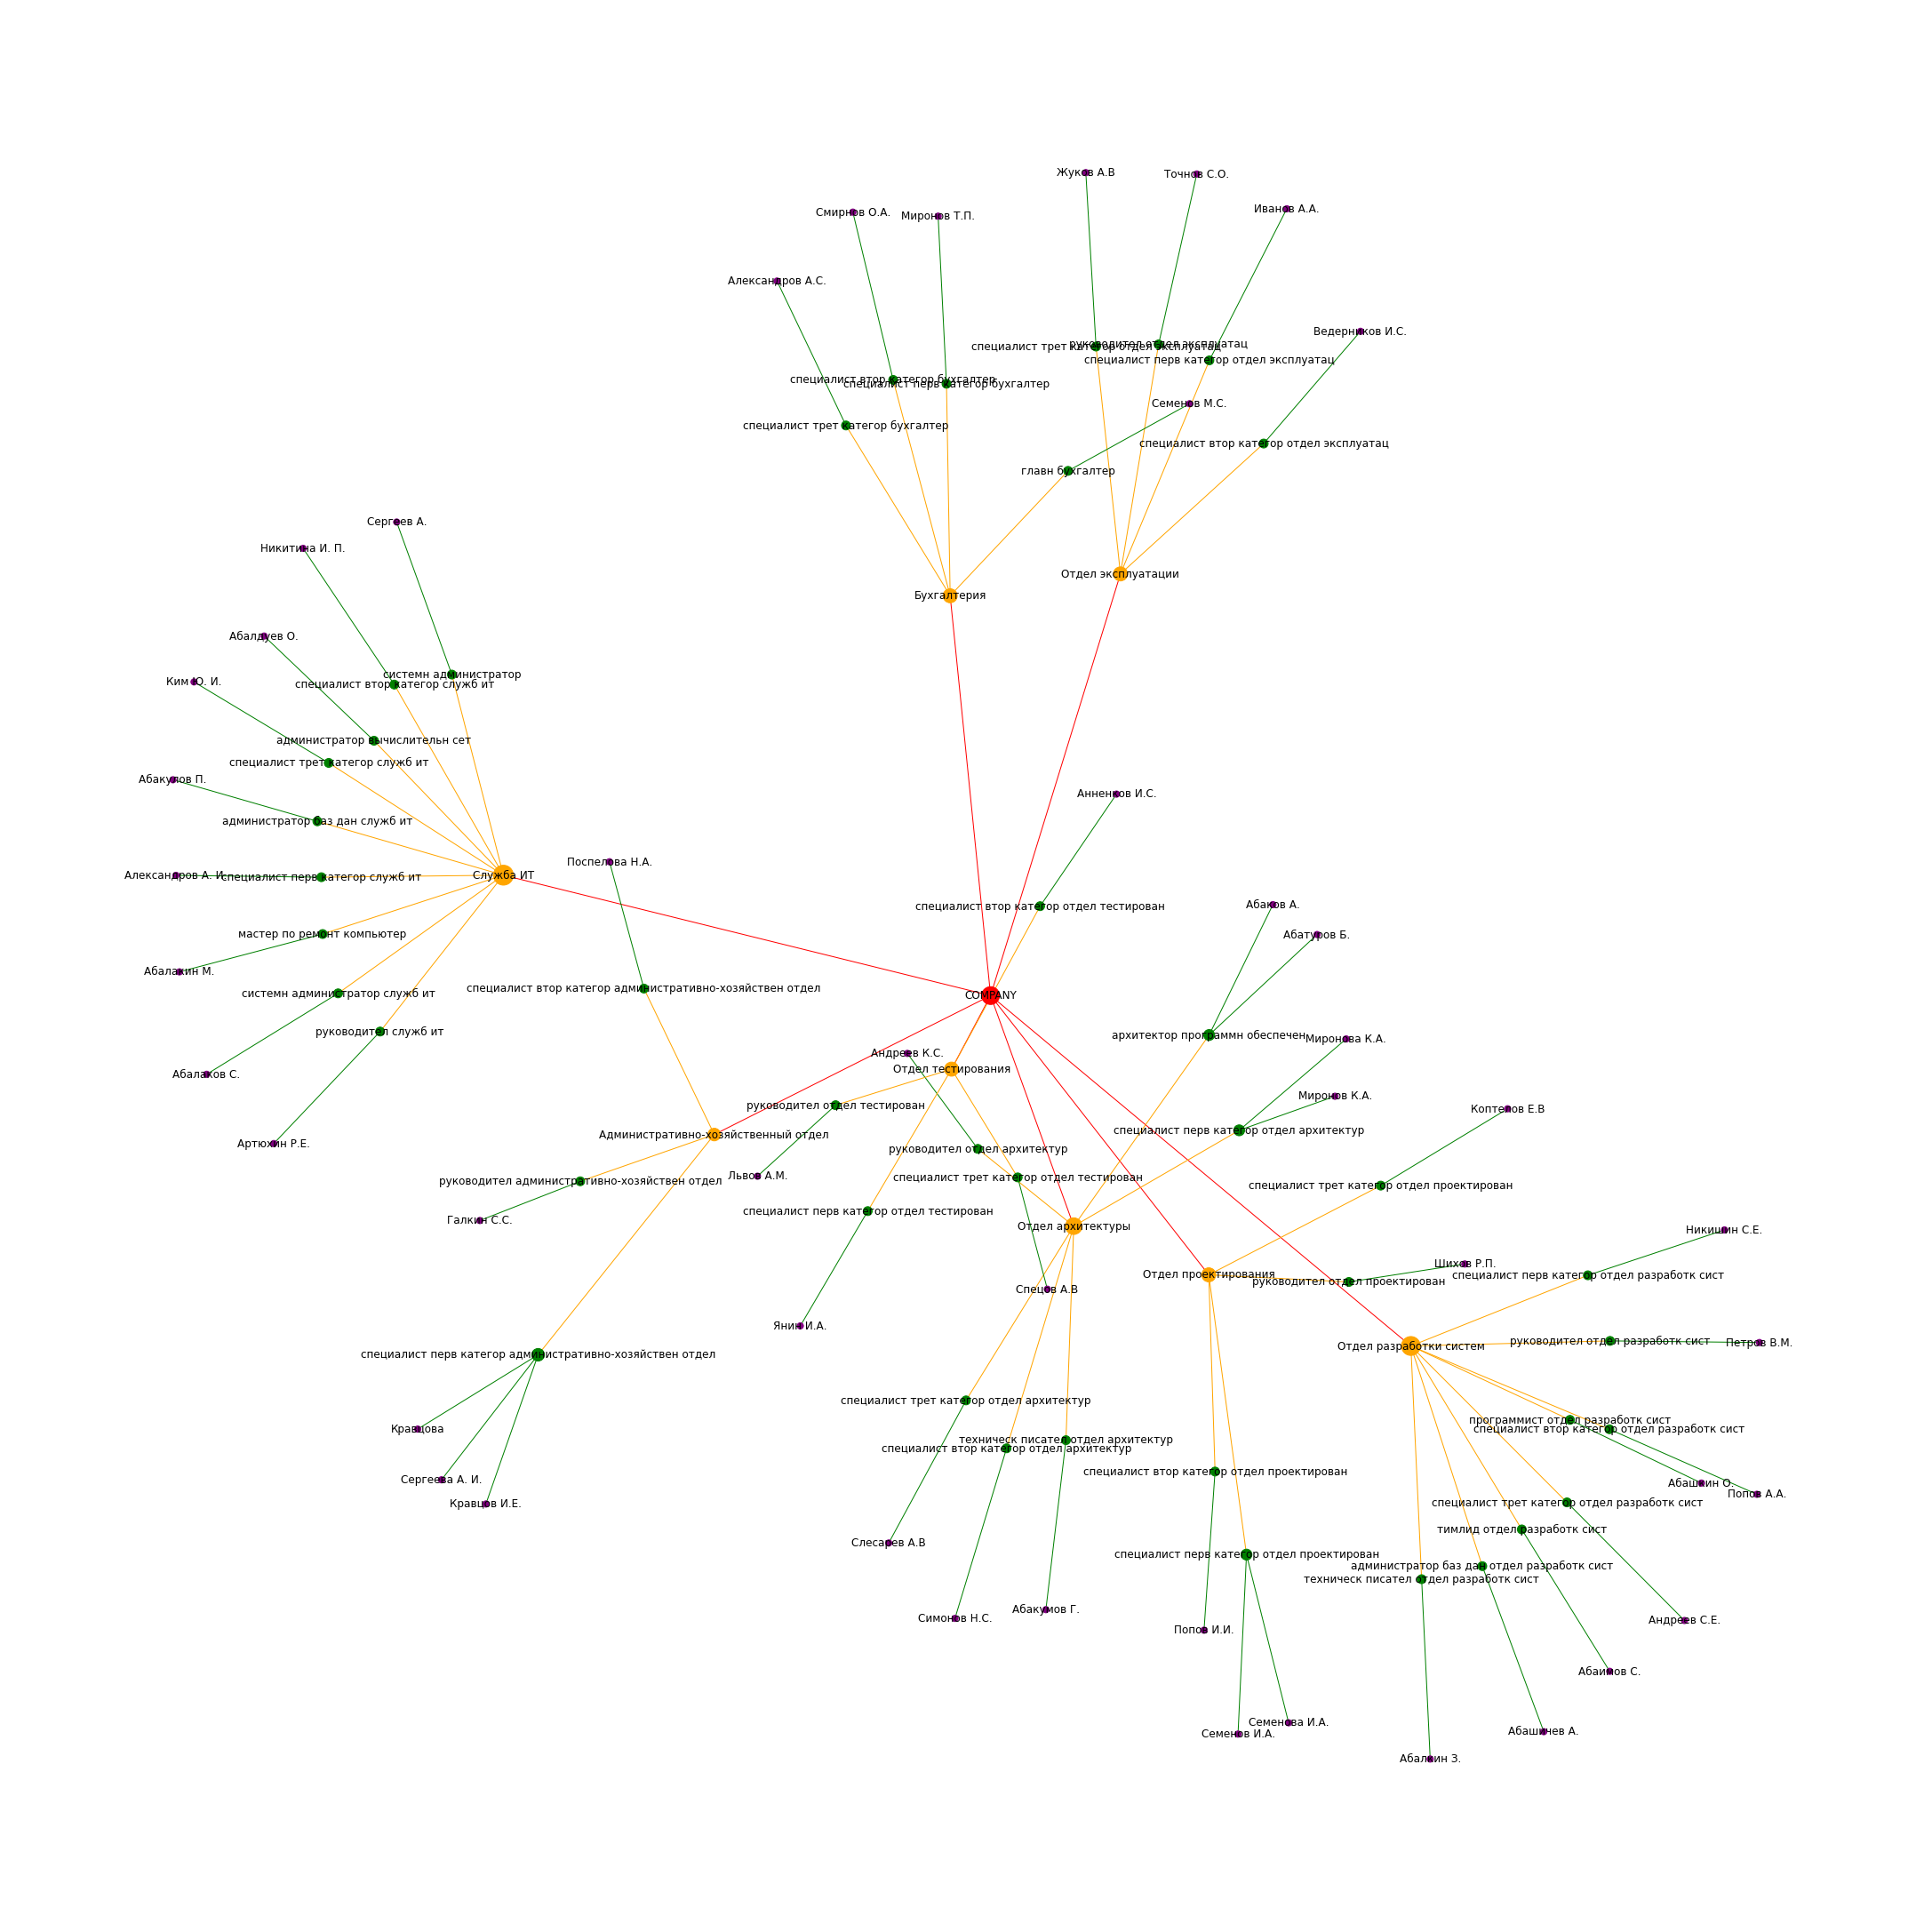

In [117]:
# create a graph object
G = nx.Graph()

comp_name = 'COMPANY'

for z in list(departments):
    G.add_edge(comp_name, z)
    # iterate through the rows of the DataFrame
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # add task_responsibles_groups node
        dept = row["dept"]
        G.add_node(dept, size=df["dept"].value_counts()[dept])
        # add position node
        position = row["position"]
        G.add_node(position, size=df["position"].value_counts()[position])
        # add name node
        name = row["name"]
        G.add_node(name, size=df["name"].value_counts()[name])
        # add edges between task_responsibles_groups and position
        G.add_edge(dept, position)
        # add edges between position and name
        G.add_edge(position, name)

# draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
pos = nx.spring_layout(G) # spring layout to calculate node positions

# create a list of node sizes
node_sizes = []
for node in G.nodes():
    node_sizes.append(G.degree(node)*50)

# create a list of node colors
node_colors = []
for node in G.nodes():
    if node in departments:
        node_colors.append("orange")
    elif node in df["position"].unique():
        node_colors.append("green")
    elif node in df["name"].unique():
        node_colors.append("purple")
    else:
        node_colors.append("red")

# create a list of edge colors
edge_colors = []
for edge in G.edges():
    if edge[0] in departments:
        edge_colors.append("orange")
    elif edge[0] in df["position"].unique():
        edge_colors.append("green")
    elif edge[0] in df["name"].unique():
        edge_colors.append("purple")
    else:
        edge_colors.append("red")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors)


# Document checker

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 9999.docx to 9999.docx
Saving 9972.docx to 9972.docx
Saving 9973.docx to 9973.docx
Saving 9974.docx to 9974.docx
Saving 9975.docx to 9975.docx
Saving 9976.docx to 9976.docx


In [ ]:
!unzip /content/docx.zip

## Parsing text from docx files

In [118]:
from docx import Document
import os
import random

def get_text(filename):
    doc = Document(f'/content/{filename}')
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

folder_path = '/content/'
docx_files = [f for f in os.listdir(folder_path) if f.endswith('.docx')]
random_file = random.choice(docx_files)

text = get_text(random_file)
if docx_files:
    random_file = random.choice(docx_files)
    text = get_text(random_file)
    print(text)
else:
    print("No docx files found in the directory")



ООО "Мегасофт"


Приказ
Для организации мероприятия "День заказчика" приказываю:
○
Установить программное обеспечение MS Word на пользовательский компьютер.
Срок выполнения поручения: 24.02.15.
Обеспечение выполнения возложить на администратора вычислительной сети Абалдуева Олега
и.о. генерального директора Сердитый А.И.
07 марта 2016 года




In [119]:
def get_text(filename):
    doc = Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

directory = '/content/'

# Create an empty dictionary to store the extracted text
text_dict = {}

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.docx'):
        file_path = os.path.join(directory, filename)
        text = get_text(file_path)
        text_dict[filename] = text

print(text_dict)

{'9973.docx': '\nООО "Мегасофт"\n\n\nПриказ\nВ связи с окончанием проекта "Внедрение системы знаний" поручаю обеспечить выполнение задач:\na)\nПровести обучение сотрудников работе с системой.\nСроком окончания работ определить 08 апреля 12.\nКонтроль над выполнением настоящего распоряжения оставляю за собой\n\t○\nОрганизовать поддержку интеграции системы со сторонним программным обеспечением.\nСроком окончания работ определить 04 октября 2016 года.\nОтветственным за исполнение настоящего приказа назначить руководителя отдела эксплуатации Департамента внедрения и эксплуатации Точнова С.О.\nи.о. генерального директора Кравцов С.С.\n17 октября 2018 года\n\n', '9972.docx': '\nООО "Мегасофт"\n\n\nПриказ\nДля организации мероприятия "День заказчика" приказываю:\n○\nУстановить программное обеспечение MS Word на пользовательский компьютер.\nСрок выполнения поручения: 24.02.15.\nОбеспечение выполнения возложить на администратора вычислительной сети Абалдуева Олега\nи.о. генерального директора С

In [ ]:
import random
import spacy
from spacy import displacy

# Load the language model
nlp = spacy.load("ru_core_news_lg")

# Select a random text from the dictionary
random_text = random.choice(list(text_dict.values()))

# Process the text and create a doc object
doc = nlp(random_text)

# Pass the doc object to displacy.render()
displacy.render(doc, style='ent', jupyter=True)



In [120]:
def im_pad(text):
  morph = pymorphy2.MorphAnalyzer()
  words = text.split()
  nominative_words = []
  for word in words:
    parsed_word = morph.parse(word)[0]
    nominative_word = parsed_word.normal_form
    nominative_words.append(nominative_word)
  nominative_sentence = " ".join(nominative_words)
  return nominative_sentence

In [121]:
def name_to_initials(full_name):
    if not full_name:
        return ""
    if '.' in full_name:
        return full_name
    name_parts = full_name.split()
    lastname = name_parts[0]
    initials = "".join([part[0] + "." for part in name_parts[1:]])
    return lastname + " " + initials

In [122]:
df_docx = pd.DataFrame(columns=['Entity', 'Type', 'File_Name'])

# Loop through the files in the dictionary
for file_name, text in text_dict.items():
    # Process the text and create a doc object
    doc = nlp(text)
    names = []
    for ent in doc.ents:
        if ent.label_ == "PER":
            names.append(ent.text)
    dict_emp = {}
    for i in names:
        dict_emp[name_to_initials(i.lower()).replace(". ", ".")] = im_pad(qa_pipeline(f"Какая должность у {i}?", text)['answer'])
    for entity, type in dict_emp.items():
        df_docx = df_docx.append({'Entity': entity, 'Type': type, 'File_Name': file_name}, ignore_index=True)

# Get all unique file names
file_names = list(set(df_docx['File_Name']))

# Assign a random color to each file name
color_map = {}

for i in range(len(file_names)):
    color = random.choice(['red', 'green', 'blue', 'purple', 'orange'])
    if i > 0:
        while color_map.get(file_names[i-1]) == color:
            color = random.choice(['red', 'green', 'blue', 'purple', 'orange'])
    color_map[file_names[i]] = color

def highlight_file(dataframe):
    df = pd.DataFrame('', index=dataframe.index, columns=dataframe.columns)
    for file_name, color in color_map.items():
        mask = dataframe['File_Name'] == file_name
        df.loc[mask, :] = 'background-color: %s' % color
    return df

df_docx.style.apply(highlight_file, axis=None)


,Entity,Type,File_Name
0,точнова с.о.,руководитель отдел эксплуатация,9973.docx
1,кравцов с.с.,генеральный директор,9973.docx
2,абалдуева о.,администратор вычислительный сеть,9972.docx
3,с.с.галкина,руководитель административно-хозяйственный отдел,9999.docx
4,кравцову и.е.,специалист первый категория административно-хозяйственный отдел,9999.docx
5,созонов с.в.,генеральный директор,9999.docx
6,точнова с.о.,руководитель отдел эксплуатация,9974.docx
7,созонов с.в.,генеральный директор,9974.docx
8,абатурова б.i.,архитектор программный обеспечение,9976.docx
9,андреева с.е.,и.о. генеральный директор,9975.docx


### Check a given name and position on the graph

In [138]:
# create a new column with default value "Decline"
df_docx["Result"] = "Decline"

# function to check if the entity and type match the name and position nodes in the graph
def match_check(row):
    if row["Entity"].lower() in [n.lower() for n in G.nodes() if "name" in n] and row["Type"].lower() in [n.lower() for n in G.nodes() if "position" in n]:
        return "Accept"
    return "Decline"

# apply the function to the DataFrame
df_docx["Result"] = df_docx.apply(match_check, axis=1)

df_docx


,Entity,Type,File_Name,Result
0,точнова с.о.,руководитель отдел эксплуатация,9973.docx,Decline
1,кравцов с.с.,генеральный директор,9973.docx,Decline
2,абалдуева о.,администратор вычислительный сеть,9972.docx,Decline
3,с.с.галкина,руководитель административно-хозяйственный отдел,9999.docx,Decline
4,кравцову и.е.,специалист первый категория административно-хо...,9999.docx,Decline
5,созонов с.в.,генеральный директор,9999.docx,Decline
6,точнова с.о.,руководитель отдел эксплуатация,9974.docx,Decline
7,созонов с.в.,генеральный директор,9974.docx,Decline
8,абатурова б.i.,архитектор программный обеспечение,9976.docx,Decline
9,андреева с.е.,и.о. генеральный директор,9975.docx,Decline


In [123]:
!pip install git+https://github.com/WojciechMula/pyahocorasick.git
!pip install pyahocorasick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/WojciechMula/pyahocorasick.git to /tmp/pip-req-build-hrw7okem
  Running command git clone --filter=blob:none --quiet https://github.com/WojciechMula/pyahocorasick.git /tmp/pip-req-build-hrw7okem
  Resolved https://github.com/WojciechMula/pyahocorasick.git to commit c98e999c7a5dcbcb8c16380a0ff96afb15065b17
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
import ahocorasick

# create an empty Automaton
A = ahocorasick.Automaton()

# insert the names of the nodes in the graph into the Automaton
for node in G.nodes():
    if "name" in node.lower() or "position" in node.lower():
        A.add_word(node.lower(), node) # add index

# finalize the Automaton
A.make_automaton()

False

In [ ]:
for node in G.nodes():
  print()

In [ ]:
import ahocorasick

# create an empty Automaton
A = ahocorasick.Automaton()

# insert the names of the nodes in the graph into the Automaton
for node in G.nodes():
    if "name" in node.lower() and "position" in node.lower():
        A.add_word(node.lower(), node)

# finalize the Automaton
A.make_automaton()

# create a new column with default value "Decline"
df_docx["Result"] = "Decline"

# function to check if the entity and type match the name and position nodes in the graph
def match_check(row):
    for end_index, original_value in A.iter(row["Entity"].lower()):
        if end_index == len(row["Entity"]) - 1:
            return "Accept"
    for end_index, original_value in A.iter(row["Type"].lower()):
        if end_index == len(row["Type"]) - 1:
            return "Accept"
    return "Decline"

# apply the function to the DataFrame
df_docx["Result"] = df_docx.apply(match_check, axis=1)


AttributeError: ignored

In [139]:
list(G.nodes)

['COMPANY',
 'Отдел разработки систем',
 'тимлид отдел разработк сист',
 'Абаимов С.',
 'Отдел архитектуры',
 'архитектор программн обеспечен',
 'Абаков А.',
 'Служба ИТ',
 'администратор баз дан служб ит',
 'Абакулов П.',
 'техническ писател отдел архитектур',
 'Абакумов Г.',
 'мастер по ремонт компьютер',
 'Абалакин М.',
 'системн администратор служб ит',
 'Абалаков С.',
 'администратор вычислительн сет',
 'Абалдуев О.',
 'техническ писател отдел разработк сист',
 'Абалкин З.',
 'Абатуров Б.',
 'администратор баз дан отдел разработк сист',
 'Абашичев А.',
 'программист отдел разработк сист',
 'Абашкин О.',
 'Бухгалтерия',
 'специалист трет категор бухгалтер',
 'Александров А.С.',
 'специалист перв категор служб ит',
 'Александров А. И.',
 'руководител отдел архитектур',
 'Андреев К.С.',
 'специалист трет категор отдел разработк сист',
 'Андреев С.Е.',
 'Отдел тестирования',
 'специалист втор категор отдел тестирован',
 'Анненков И.С.',
 'Отдел эксплуатации',
 'специалист втор категор

In [137]:
import pymorphy2
def is_name_position_in_graph(G, name, position):
    if not name and not position:
        return False
    morph = pymorphy2.MorphAnalyzer()
    if name:
        name_norm = morph.parse(name)[0].normal_form
    if position:
        position_norm = morph.parse(position)[0].normal_form

    for node in G.nodes():
        if name:
            node_norm = morph.parse(node)[0].normal_form
            if node_norm != name_norm:
                continue
        if position:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                neighbor_norm = morph.parse(neighbor)[0].normal_form
                if neighbor_norm == position_norm:
                    return True
    return False


In [ ]:
for i in range(len(list(dict_emp.values()))):
    print("name: ", list(dict_emp)[i], " | ",
          "position: ", list(dict_emp.values())[i], " | ",
          "result: ", is_name_position_in_graph(G, list(dict_emp)[i], list(dict_emp.values())[i]))
    # print(is_name_position_in_graph(G, list(dict_emp)[i], list(dict_emp.values())[i]))

name:  андреева с.е.  |  position:  и.о. генеральный директор  |  result:  False


In [ ]:
name = 'семёнов м.с.'
position = 'главн бухгалтер'
print(is_name_position_in_graph(G, name, position))

False


# Graph finding paths

In [ ]:
results = []
for n1 in G.nodes():
    for n2 in G.nodes():
        shortest_path = nx.single_source_dijkstra(G, source=n1, target=n2)
        results.append(shortest_path)


In [ ]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)


(3, ['ведерников и.с.', 'втор категор отдел эксплуатац', 'Отдел эксплуатации', 'COMPANY'])


# Helper functions

In [ ]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)

(3, ['ведерников и.с.', 'втор категор отдел эксплуатац', 'Отдел эксплуатации', 'COMPANY'])


Is a given person works in the company

In [ ]:
def is_employee(graph, company, name):
  try:
    shortest_path = nx.single_source_dijkstra(G, source=company, target=name)
    print(shortest_path)
    if shortest_path[0] == 3 and shortest_path[1][-1] == name:
      return True
    else:
      return False
  except:
    return False

is_employee(G, 'COMPANY', 'ведерников и.с.')

(3, ['COMPANY', 'Отдел разработки систем', 'втор категор', 'ведерников и.с.'])


True

In [ ]:
is_employee(G, 'COMPANY', 'абатуров б.')

(3, ['COMPANY', 'Отдел архитектуры', 'архитектор программн обеспечен', 'абатуров б.'])


True

In [ ]:
is_employee(G, 'COMPANY', 'обатуров б.')

False

Is a given person works in the company